In [23]:
# https://arxiv.org/abs/2410.01201
# were RNNs All We Needed? 

from tqdm import tqdm
import torch
import tiktoken
import urllib.request

enc = tiktoken.get_encoding("gpt2")
url = 'https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt'
filename = 'shakespeare.txt'
urllib.request.urlretrieve(url, filename)

docs = open("shakespeare.txt", "r").read().splitlines()
len(docs)

40000

In [ ]:
tokens= set(enc.encode(" ".join(docs)))
tokens_ids = [int(i) for i in tokens]
Vocab = {}

for i in tokens_ids:
    token = enc.decode([i])
    Vocab[token] = i
itos ={i:s for s,i in Vocab.items()}

vocab_size = len(Vocab)
print(vocab_size)


11387


In [25]:
block_size = 64 # context length: how many tokens do we take to predict the next one?

def build_dataset(docs):  
    X, Y = [], []
  
    for doc in docs:
        context = [0] * block_size
        for token in doc:
            ix = Vocab.get(token)
            if ix is None:
                continue  # skip token if it's not in the vocabulary
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X, dtype=torch.long)
    Y = torch.tensor(Y, dtype=torch.long)
    print(f"X shape: {X.shape}, Y shape: {Y.shape}")
    return X, Y

n = int(len(docs) * 0.9)
Xtr, Ytr = build_dataset(docs[:n])
Xte, Yte = build_dataset(docs[n:])

X shape: torch.Size([978353, 64]), Y shape: torch.Size([978353])
X shape: torch.Size([95053, 64]), Y shape: torch.Size([95053])


In [26]:
n_embd = 10
hidden_size = 256
block_size = 64
batch_size = 32 

g = torch.Generator().manual_seed(983245) # for reproducibility
C = torch.randn((vocab_size, n_embd),                   generator=g)
# Parameters for the first minGRU layer
Zt1_W  = torch.randn((block_size * n_embd, hidden_size), generator=g) * (1)/((block_size * n_embd)**0.5)
Zt1_B  = torch.randn (hidden_size                      , generator=g) * 0 
Ht1_W  = torch.randn((block_size * n_embd, hidden_size), generator=g) * (1)/((block_size * n_embd)**0.5)
Ht1_B  = torch.randn(hidden_size                       , generator=g) * 0

# Parameters for the second min GRU layer
Zt2_W = torch.randn((hidden_size, hidden_size),         generator=g) * (1)/((hidden_size)**0.5) # input-to-gate
Zt2_B = torch.randn(hidden_size,                        generator=g) * 0
Ht2_W = torch.randn((hidden_size, hidden_size),         generator=g) * (1)/((hidden_size)**0.5) # input-to-candidate
Ht2_B = torch.randn(hidden_size,                        generator=g) * 0
W     = torch.randn((hidden_size, vocab_size),          generator=g) * 0.01
B     = torch.randn(vocab_size) * 0


# BatchNorm parameters
bngain = torch.ones((1, hidden_size))
bnbias = torch.zeros((1, hidden_size))
bnmean_running = torch.zeros((1, hidden_size))
bnstd_running = torch.ones((1, hidden_size))

bngain2 = torch.ones((1, hidden_size))
bnbias2 = torch.zeros((1, hidden_size))
bnmean_running2 = torch.zeros((1, hidden_size))
bnstd_running2 = torch.ones((1, hidden_size))

parameters = [C, Zt1_W, Zt1_B, Ht1_W, Ht1_B, Zt2_W, Zt2_B, Ht2_W, Ht2_B, W, B, bngain, bnbias, bngain2, bnbias2]
print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}") # number of parameters in total
for p in parameters:
  p.requires_grad = True




Total number of parameters: 3501129


In [27]:
max_steps = 200000
lossi = []

loss_fn = torch.nn.CrossEntropyLoss()
# x_t: (batch_size, input_size)
# h_prev: (batch_size, hidden_size)
for step in tqdm(range(max_steps), desc='Training Progress', unit=' steps'):
    minibatch = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[minibatch], Ytr[minibatch]
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    Ztpreact = embcat @ Zt1_W + Zt1_B
    Htilde = embcat @ Ht1_W + Ht1_B 

    bnmeani = Ztpreact.mean(0, keepdim=True)
    bnstdi = Ztpreact.std(0, keepdim=True)
    Ztpreact = bngain * (Ztpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi 
        
    Zt =  torch.sigmoid(Ztpreact) 
    H1_t = (1-Zt) * torch.zeros_like(Zt) + Zt * Htilde # first hidden state | output from the first minGRU layer
    
    # second layer
    Ztpreact2 = H1_t @ Zt2_W + Zt2_B
    
    bnmeani2 = Ztpreact.mean(0, keepdim=True)
    bnstdi2 = Ztpreact.std(0, keepdim=True)
    Ztpreact2 = bngain2 * (Ztpreact2 - bnmeani2) / bnstdi2 + bnbias2
    with torch.no_grad():
        bnmean_running2 = 0.999 * bnmean_running2 + 0.001 * bnmeani2
        bnstd_running2 = 0.999 * bnstd_running2 + 0.001 * bnstdi2

    Zt2 = torch.sigmoid(Ztpreact2)
    Htilde2 = H1_t @ Ht2_W + Ht2_B
    H2_t = (1 - Zt2) * H1_t + Zt2 * Htilde2
    
    # linear layer  
    outputs = H2_t @ W + B 
    loss = loss_fn(outputs.view(-1, vocab_size), Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if step < 50000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if step % 5000 == 0:
        tqdm.write(f'Step {step}, Loss: {loss.item()}')
    if step % 1000 == 0:
        lossi.append(loss.item())

print(f"Final Loss: {lossi[-1]}")


Training Progress:   0%|          | 4/200000 [00:00<5:14:34, 10.60 steps/s] 

Step 0, Loss: 9.33500862121582


Training Progress:   3%|▎         | 5013/200000 [01:17<48:06, 67.55 steps/s]  

Step 5000, Loss: 2.1451380252838135


Training Progress:   5%|▌         | 10008/200000 [02:56<49:51, 63.52 steps/s] 

Step 10000, Loss: 1.7346588373184204


Training Progress:   8%|▊         | 15007/200000 [04:39<54:48, 56.26 steps/s]  

Step 15000, Loss: 1.464119553565979


Training Progress:  10%|█         | 20011/200000 [06:02<49:04, 61.12 steps/s]  

Step 20000, Loss: 2.1823103427886963


Training Progress:  13%|█▎        | 25005/200000 [07:24<1:09:21, 42.06 steps/s]

Step 25000, Loss: 1.5935108661651611


Training Progress:  15%|█▌        | 30014/200000 [08:41<37:51, 74.84 steps/s]  

Step 30000, Loss: 1.4746524095535278


Training Progress:  18%|█▊        | 35008/200000 [09:59<47:10, 58.29 steps/s]  

Step 35000, Loss: 1.3238582611083984


Training Progress:  20%|██        | 40008/200000 [11:20<1:09:32, 38.34 steps/s]

Step 40000, Loss: 2.0624313354492188


Training Progress:  23%|██▎       | 45012/200000 [12:41<37:25, 69.01 steps/s]  

Step 45000, Loss: 1.115250825881958


Training Progress:  25%|██▌       | 50011/200000 [13:59<34:53, 71.65 steps/s]  

Step 50000, Loss: 1.4705991744995117


Training Progress:  28%|██▊       | 55013/200000 [15:17<36:55, 65.46 steps/s]  

Step 55000, Loss: 1.5026473999023438


Training Progress:  30%|███       | 60010/200000 [16:46<39:55, 58.43 steps/s]  

Step 60000, Loss: 1.2411000728607178


Training Progress:  33%|███▎      | 65010/200000 [18:11<34:25, 65.35 steps/s]  

Step 65000, Loss: 1.2024791240692139


Training Progress:  35%|███▌      | 70012/200000 [19:30<33:55, 63.88 steps/s]

Step 70000, Loss: 1.5710220336914062


Training Progress:  38%|███▊      | 75011/200000 [20:54<35:29, 58.69 steps/s]  

Step 75000, Loss: 1.961722731590271


Training Progress:  40%|████      | 80007/200000 [22:17<32:33, 61.43 steps/s]  

Step 80000, Loss: 1.356242060661316


Training Progress:  43%|████▎     | 85011/200000 [23:59<30:05, 63.69 steps/s]  

Step 85000, Loss: 1.6090885400772095


Training Progress:  45%|████▌     | 90011/200000 [25:37<31:28, 58.23 steps/s]  

Step 90000, Loss: 1.305763602256775


Training Progress:  48%|████▊     | 95008/200000 [27:04<26:50, 65.20 steps/s]  

Step 95000, Loss: 1.2014031410217285


Training Progress:  50%|█████     | 100015/200000 [28:28<24:04, 69.20 steps/s] 

Step 100000, Loss: 1.7710658311843872


Training Progress:  53%|█████▎    | 105004/200000 [29:55<22:46, 69.52 steps/s]  

Step 105000, Loss: 1.6780093908309937


Training Progress:  55%|█████▌    | 110009/200000 [31:33<32:57, 45.52 steps/s]  

Step 110000, Loss: 1.7410495281219482


Training Progress:  58%|█████▊    | 115007/200000 [33:18<39:55, 35.47 steps/s]  

Step 115000, Loss: 1.3741750717163086


Training Progress:  60%|██████    | 120012/200000 [35:11<22:38, 58.86 steps/s]  

Step 120000, Loss: 1.6957706212997437


Training Progress:  63%|██████▎   | 125010/200000 [36:35<17:54, 69.80 steps/s]

Step 125000, Loss: 1.5061968564987183


Training Progress:  65%|██████▌   | 130003/200000 [38:04<24:25, 47.75 steps/s]

Step 130000, Loss: 1.4279067516326904


Training Progress:  68%|██████▊   | 135010/200000 [39:39<20:02, 54.04 steps/s]

Step 135000, Loss: 1.4443155527114868


Training Progress:  70%|███████   | 140009/200000 [41:17<16:16, 61.43 steps/s]

Step 140000, Loss: 1.4197590351104736


Training Progress:  73%|███████▎  | 145009/200000 [42:51<16:10, 56.67 steps/s]

Step 145000, Loss: 1.393819808959961


Training Progress:  75%|███████▌  | 150007/200000 [44:35<20:25, 40.80 steps/s]  

Step 150000, Loss: 1.3347065448760986


Training Progress:  78%|███████▊  | 155009/200000 [46:07<13:39, 54.92 steps/s]

Step 155000, Loss: 1.4302613735198975


Training Progress:  80%|████████  | 160012/200000 [47:41<15:24, 43.27 steps/s]

Step 160000, Loss: 1.1668381690979004


Training Progress:  83%|████████▎ | 165010/200000 [48:57<08:20, 69.92 steps/s]

Step 165000, Loss: 1.2690248489379883


Training Progress:  85%|████████▌ | 170008/200000 [50:11<07:20, 68.11 steps/s]

Step 170000, Loss: 1.1797893047332764


Training Progress:  88%|████████▊ | 175010/200000 [51:24<05:53, 70.64 steps/s]

Step 175000, Loss: 1.3875898122787476


Training Progress:  90%|█████████ | 180010/200000 [52:38<04:48, 69.27 steps/s]

Step 180000, Loss: 1.429744839668274


Training Progress:  93%|█████████▎| 185012/200000 [53:52<03:30, 71.30 steps/s]

Step 185000, Loss: 1.270566701889038


Training Progress:  95%|█████████▌| 190008/200000 [55:05<02:27, 67.94 steps/s]

Step 190000, Loss: 1.4654666185379028


Training Progress:  98%|█████████▊| 195012/200000 [56:18<01:12, 69.03 steps/s]

Step 195000, Loss: 1.3913280963897705


Training Progress: 100%|██████████| 200000/200000 [57:27<00:00, 58.01 steps/s]

Final Loss: 1.414941668510437


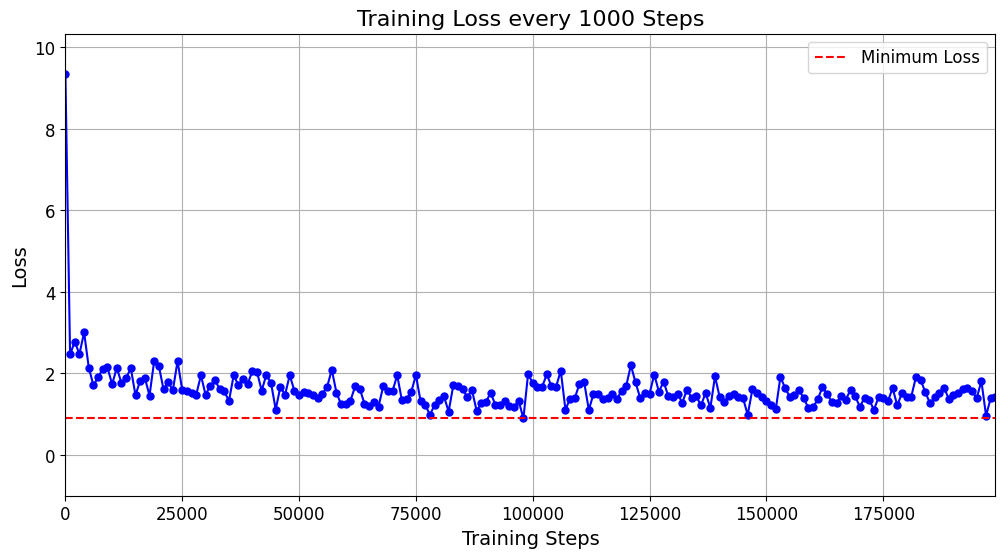

In [28]:
import matplotlib.pyplot as plt



steps = list(range(0, len(lossi) * 1000, 1000))  # Assuming loss is recorded every 1000 steps

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(steps, lossi, marker='o', color='b', linestyle='-', markersize=5)
plt.title('Training Loss every 1000 Steps', fontsize=16)
plt.xlabel('Training Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xlim(0, max(steps))
plt.ylim(-1, max(lossi) + 1)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=min(lossi), color='r', linestyle='--', label='Minimum Loss')
plt.legend(fontsize=12)
plt.show() 

In [29]:
with torch.no_grad():
    testLoss = 0.0
    correct_predictions = 0  # For tracking correct next word predictions

    for i in range(0, Xte.shape[0]):
        x, y = Xte[i].unsqueeze(0), Yte[i].unsqueeze(0)
        if (x >= vocab_size).any():  # If there are any invalid tokens
            print(f"Skipping example {i} due to out-of-vocabulary tokens.")
            continue
        emb = C[x]
        embcat = emb.view(emb.shape[0], -1)
        Ztpreact = embcat @ Zt1_W + Zt1_B
        Htilde = embcat @ Ht1_W + Ht1_B
        Ztpreact = bngain * (Ztpreact - bnmeani) / bnstdi + bnbias
        Zt = torch.sigmoid(Ztpreact)
        H1_t = (1 - Zt) * torch.zeros_like(Zt) + Zt * Htilde
        Ztpreact2 = H1_t @ Zt2_W + Zt2_B
        Htilde2 = H1_t @ Ht2_W + Ht2_B
        Ztpreact2 = bngain2 * (Ztpreact2 - bnmeani2) / bnstdi2 + bnbias2
        Zt2 = torch.sigmoid(Ztpreact2)
        H2_t = (1 - Zt2) * H1_t + Zt2 * Htilde2
        output = H2_t @ W + B  # Output logits

        # logits to probabilities 
        probs = torch.nn.functional.softmax(output, dim=-1)
        _, predicted_next_word = torch.max(probs, dim=1)
        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(output.view(-1, vocab_size), y)

        testLoss += loss.item()

    average_loss = testLoss / Xte.shape[0]

    print(f"Test Loss: {average_loss}")


Test Loss: 1.8353070663409043


In [ ]:
UNK_TOKEN = '<UNK>' 

for i in range(20):  
    out = [] 
    context = [0] * block_size  

    while True:
        emb = C[torch.tensor(context)]
        embcat = emb.view(1, -1)
        Ztpreact = embcat @ Zt1_W + Zt1_B
        Htilde = embcat @ Ht1_W + Ht1_B
        Zt = torch.sigmoid(Ztpreact)
        H1_t = (1 - Zt) * torch.zeros_like(Zt) + Zt * Htilde
        Ztpreact2 = H1_t @ Zt2_W + Zt2_B
        Htilde2 = H1_t @ Ht2_W + Ht2_B
        Zt2 = torch.sigmoid(Ztpreact2)
        H2_t = (1 - Zt2) * H1_t + Zt2 * Htilde2
        output = H2_t @ W + B
        probs = torch.nn.functional.softmax(output, dim=1)
        # Sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break
    decoded_output = ''.join(itos[i] if i in itos.keys() else UNK_TOKEN for i in out)
    print(f"Generated Example {i}: {decoded_output}")

Generated Example 0: RUTLAND:BY: I will Edward's and mouth apousin's frow? Doods. Offends. Murs. Cumiz--not receld. Bumintaged on<UNK>. God fay's,--would I say, at Apronl!
Generated Example 1: As too love be; Ifare 'Theseen an the eart; and, to her Ritcless place mother's Come. You,--<UNK>on,, Coring-gor-enjy. I teld:--help? I'lly? I: Rornicked years. Oxp AUEd:a: a whillison!
Generated Example 2: Catest have so her more of days. Unmens' there, not beginger and browel thenother; I will. Forse: exmarn onfonges. Gears, angeemen; anring--forb'd se's be ship, wing. MEWLLO:: by CONDCY: G<UNK>UNCY: buiNe Cauuler Gordeath; gardy. Do; comalth. I say-too; non. I kneeth. Edward's Kittll. I; young.s'?,n. I:eselt<UNK>er; I fould:--Iet. Margetia;flengr endeed. Beant. Tendgueser; I'll be rone..' the vall fixtr<UNK><UNK>gour bandsal.e: but foest Doush'd. DousyagonidingHord. Goducie!
Generated Example 3: Hour hand spurse thy vour I will ne with sleep branking.re, sick, by lay hers<UNK>? BupitBed, I fay